## Project description

This is a exercise on kaggle knowledge, our goal is trying to predict the survived or not. Features, 
such as Pclass,'sex','fare' are examined.Name column is preprocessed with string function,generated
with a title column as a predicting feature.
Classifer of Naievebayes,adaboost,randoforest has been applied to predict and validated by the corresponding
datasets, then grid serach has been applied to ahead best performer



## import modules

In [241]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from visuals import evaluate
from IPython.display import display
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.naive_bayes  import GaussianNB
from sklearn.svm import SVC
from  sklearn.ensemble  import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier



## load data

In [3]:
with ZipFile('titanic.zip','r') as titanic:
    titanic.extractall()
    titanic.close()

In [103]:
train_df = pd.read_csv('train.csv')

In [605]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 with intuition and general knowledege inspect pclass, sex, age with relationship of surivial rate

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [607]:
train_df.describe()  #Age has 177 of missing values

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## explore the relation between survived rate vs columns

In [11]:
train_df.corr() # Pclass and Fare have a high correlation coefficient to survived rate, 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


- Pclass,Class 1 have a higher survived rate,class 3 gives a smaller survived rate

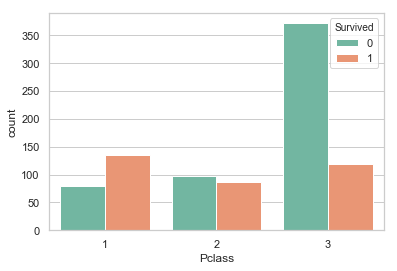

In [91]:
ax1 = sns.countplot(x = 'Pclass',hue = 'Survived',data = train_df ,palette="Set2")

- fare, Spending more,higher survived rate( which is correlated to the pclass,according to general knowledge)

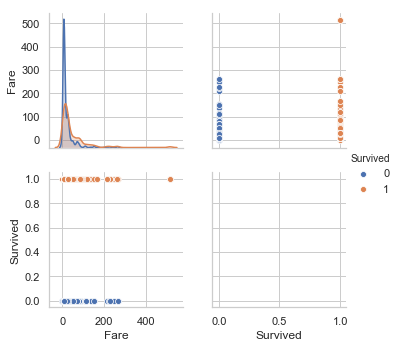

In [28]:
sns.pairplot(hue = 'Survived',data = train_df[['Fare','Survived']]) 

- categorical data,sex, femal have a much better chance to be survived

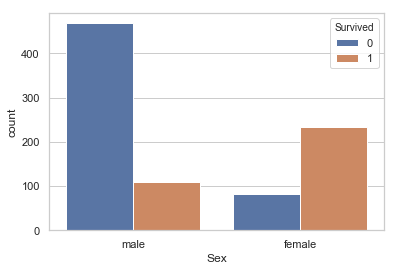

In [609]:
ax2 = sns.countplot(x = 'Sex',hue = 'Survived',data = train_df)

## name, which has a indication for sex and age,such as master, miss

- Preprocess name column to generate a title column

In [108]:
def split_name(df,col_name,new_name):
    
    miss_ = ['Mlle','Ms','Mme','Lady','theCountess','Dona']
    mr_ = ['Don','Rev','Col','Major','Jonkheer','Sir','Capt']
    
#     extract out title frome col_name
    split_arr = df[col_name].str.split(',')
    result = []
    for i in range(len(split_arr)):
         result.append(split_arr[i][1].split('.')[0].replace(' ',''))
#     group the new titles
    for i in range(len(result)):
        if result[i]  in miss_:
            result[i] = 'Miss'
        elif result[i] in mr_:
            result[i] = 'Mr'
    
    df[new_name] = result
    
    return df

In [109]:
df_split = split_name(train_df,'Name','Title')

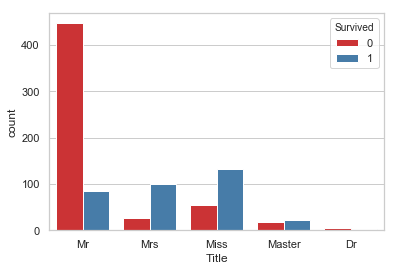

In [110]:
ax2 = sns.countplot(x = 'Title',hue = 'Survived',data = train_df,palette="Set1")

## High related fetures to lable 'survived'
- Pclass,Fare(correlated of those two)
- Sex,Title
- select features to feed to algorithm(Pcalss,Sex, Title)
- add new feature,per spare for travelling group(fare/people who travelled together)

In [199]:

def preprocess_train(df):
    ''' function to preprocess input dataframe, returns cleaned dataframe for training
    input,datafraem
    
    actions have been taken,
    genreating new feature,'per_spare',and buketlize  it
    getting dummy variable for 'Pclass',
    mapping set to 0 and 1
    generating new feature,title and have it dummirized
    
    output, cleaned dataframe
    '''

    preprocessed_df = df.copy()
    preprocessed_df = split_name(preprocessed_df,'Name','Title')
#     pre_train_df['family_size'] = pre_train_df['Parch'] + pre_train_df['SibSp']
#     pre_train_df['SibSp'] = pd.cut(pre_train_df['SibSp'],bins =[-0.1,0,1,3.0,9.0])
    pclass= pd.get_dummies(preprocessed_df['Pclass'],prefix = 'Pclass')
#     convert title to dummy variables
    titles = pd.get_dummies(preprocessed_df['Title'])
#      convert sex to binary data
    preprocessed_df['Sex'] = preprocessed_df['Sex'].map({'female':0,'male':0})
#   cal per_fare to invidual travellers    
    per_fare = cal_per_fare(preprocessed_df)    
    per_fare = pd.qcut(per_fare['per_spare'],q = 12)
    per_fare = pd.get_dummies(per_fare,prefix = 'fare')
#     merge df with preprocess
    preprocessed_df = pd.merge(preprocessed_df,titles,left_index =True,right_index =True)
    preprocessed_df = pd.merge(preprocessed_df,pclass,left_index =True,right_index =True)
    preprocessed_df = pd.merge(preprocessed_df,per_fare,left_index =True,right_index =True)
#     drop extra columns
    preprocessed_df.drop(['Title','Name','SibSp','Parch','Fare','Pclass'],axis = 1,inplace =True)
    
    return preprocessed_df

## perform data cleaning

In [200]:
train_df = pd.read_csv('train.csv')
feature_cols = ['Pclass','Name','SibSp','Parch','Fare','Sex']
X = preprocess_train(train_df[feature_cols])
y = train_df['Survived']

In [201]:
X.head()

,Sex,Dr,Master,Miss,Mr,Mrs,Pclass_1,Pclass_2,Pclass_3,"fare_(-0.001, 4.815]",...,"fare_(6.75, 7.25]","fare_(7.25, 7.775]","fare_(7.775, 7.92]","fare_(7.92, 8.3]","fare_(8.3, 10.5]","fare_(10.5, 13.0]","fare_(13.0, 23.667]","fare_(23.667, 29.7]","fare_(29.7, 44.972]","fare_(44.972, 512.329]"
0,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [202]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

##  split dataset as train and valiation

In [203]:
X_train, X_valid, y_train,y_valid = train_test_split(X,y,test_size = 0.2,random_state = 42,stratify = y)

In [204]:
sum(y_train ==1) / len(y_train) *100

38.342696629213485

In [205]:
sum(y_valid ==1) / len(y_valid) *100

38.547486033519554

##  Evaluating Model Performance

In this case, model is capable to predict the one survied or not is equally important, then we use **accuracy for** evaluating the model, but ture positive and true negative is imporant.

## Naieve model

In [206]:
# we can have a naive model to predict all the passengers will survived.
TP = np.sum(y)
FP = len(y) - TP

TN = 0
FN = 0

#  Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP+FP+TN +FN )
# accuracy
recall = TP / (TP + FN)
precision = TP/(TP + FP)

# # Calculate F-score using the formula above for beta = 1 and correct values for precision and recall.
fscore = (1+1**2)*(precision * recall  / (1**2*precision + recall))

# # Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3838, F-score: 0.5547]



## Training Function

In [207]:
def train_and_validation(learner,x_train,y_train,x_valid,y_valid):

    '''
    inputs:
    - learner: the learning algorithm to be trained and predicted on
    - X_train: features training set
    - y_train: survived training set
    - X_valid: features testing set
    - y_valid: survived testing set
    '''
    result = {}
    learner.fit(x_train,y_train)

    #     get the prediction on validation and train datasets
    pred_valid = learner.predict(x_valid)
    pred_train = learner.predict(x_train)
#     print('pred_valid',pred_valid)
#     plot_confusion_matrix(y_valid, pred_valid, 'survived',
#                           normalize=False,
#                           title=None,
#                           cmap=plt.cm.Blues)
    #     get the accuracy score and f_beta score for 
    result['acc_valid'] = accuracy_score(y_true = y_valid,y_pred = pred_valid)
    print('accuracy score',accuracy_score(y_true = y_valid,y_pred = pred_valid))
    result['f_valid'] = fbeta_score(y_true = y_valid,y_pred = pred_valid,beta = 1)

    print("{} trained on .".format(learner.__class__.__name__))
    return result
    

## Train on classifier

In [244]:
clf_A = GaussianNB()
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = RandomForestClassifier(random_state = 42)
clf_D = GradientBoostingClassifier()



results = {}
for clf in [clf_A, clf_B,clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_and_validation(clf,  X_train, y_train, X_valid, y_valid)
#     results[clf_name] = train_and_validation(clf,  X,y)

# Run metrics visualization for the three supervised learning models chosen
results = pd.DataFrame(results)

accuracy score 0.7597765363128491
GaussianNB trained on .
accuracy score 0.8212290502793296
AdaBoostClassifier trained on .
accuracy score 0.7877094972067039
RandomForestClassifier trained on .
accuracy score 0.7932960893854749
GradientBoostingClassifier trained on .


D:\Program Files (x86)\conda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [245]:
results

,GaussianNB,AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
acc_valid,0.759777,0.821229,0.787709,0.793296
f_valid,0.722581,0.746032,0.703125,0.678261


In [264]:


# Grid search and random serachon adaboost classifer

clf = AdaBoostClassifier(random_state = 42)
base_est = [ExtraTreeClassifier(),DecisionTreeClassifier()]
# searching paratmeters and scoring
parameters = {'base_estimator':base_est, 'n_estimators': [10,20,50,60,70,100,150] ,'learning_rate': [0.001,0.01,0.3,0.5,1.0]}
scorer = make_scorer(accuracy_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV( clf, parameters, scoring = scorer)
# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_valid)

best_predictions = best_clf.predict(X_valid)
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_valid, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_valid, best_predictions)))


D:\Program Files (x86)\conda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8212

Optimized Model
------
Final accuracy score on the testing data: 0.7989


##  Predict on test data with Clf_A

In [261]:
test_df = pd.read_csv('test.csv')

In [220]:

X_test = preprocess_train(test_df[feature_cols])
test_df['Survived'] = clf.predict(X_test )

## Write predction result to CSV file

In [221]:
test_df[['Survived','PassengerId']].to_csv('Passenger_submission_1.csv',index =False)

## Further working to add additional features(improved 3% percent of accuracy)

## adding new feature to dataframe,used in traning process

In [94]:
def cal_per_fare(df):
    
    per_spare = {}
    
    for i in range(len(df)):
        
        if df['SibSp'][i] ==  0 and df['Parch'][i]==  0:
            per_spare[i] = df['Fare'][i]
        else:
            per_spare[i] = df['Fare'][i] / (df['SibSp'][i] + df['Parch'][i]+1)
            
    per_spare_df = pd.DataFrame(list(per_spare.items()),columns = ['index','per_spare'],index = list(per_spare.keys()))
#     per_spare_df.reset_index(inplace =True)
    per_spare_df.set_index('index',inplace = True)
    
    return per_spare_df

        